# Tarefa Dataset Grupo

### Produção Energética e Sustentabilidade

https://www.kaggle.com/competitions/daasbstp2023

Imports Necessários

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
#USING CROSS VALIDATION
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import re
import seaborn as sns


Ingestão de Dados

In [7]:
df_energia_2021 = pd.read_csv('energia_202109-202112.csv')
print (df_energia_2021.size)
df_energia_2022 = pd.read_csv('energia_202201-202212.csv')
df_meteo_2021 = pd.read_csv('meteo_202109-202112.csv')
df_meteo_2022 = pd.read_csv('meteo_202201-202212.csv')

#ver os cabeçalhos para fazer merge por data e hora

print(df_energia_2021.head())
print(df_meteo_2021.head())


# o dia era interessante fazer com o dia do ano -1 até 365. Não há anos bissextos, não há problema
print (df_meteo_2021.dtypes)
print (df_energia_2021.dtypes)
print (df_meteo_2021['dt_iso'])
form = re.compile(r'(\d{4}-\d{2}-\d{2})\s(\d{2}):\d{2}:\d{2}\s\+\d{4}\sUTC')
#df_meteo_2021['Data'],df_meteo_2021['Hora'] =df_meteo_2021['dt_iso'].str.extract(form)

#desdobrar data para o dataset meteorológico de 2021
data= df_meteo_2021['dt_iso'].str.extract(form)
df_meteo_2021['Data']= data[0]
df_meteo_2021['Hora']= pd.to_numeric(data[1])
#df_meteo_2021['Data'], df_meteo_2021['Hora'] = zip(*df_meteo_2021['dt_iso'].str.extract(form).values)
df_meteo_2021.drop(['dt_iso'], axis='columns', inplace=True)

#desdobrar data para o dataset meteorológico de 2022
data= df_meteo_2022['dt_iso'].str.extract(form)
df_meteo_2022['Data']= data[0]
df_meteo_2022['Hora']= pd.to_numeric(data[1])
#df_meteo_2022['Data'], df_meteo_2022['Hora'] = zip(*df_meteo_2022['dt_iso'].str.extract(form).values)
df_meteo_2022.drop(['dt_iso'], axis='columns', inplace=True)

print (df_meteo_2021.head())
print (df_meteo_2022.head())

df_2021 = pd.merge(df_energia_2021,df_meteo_2021, how='inner', on=['Data','Hora']) 
df_2022 = pd.merge(df_energia_2022,df_meteo_2022, how='inner', on=['Data','Hora'])

df_train= pd.concat([df_2021, df_2022], ignore_index=True)

##TESTE

df_energia_2023 = pd.read_csv('energia_202301-202304.csv')
df_meteo_2023 = pd.read_csv('meteo_202301-202304.csv')

#desdobrar data para o dataset meteorológico de 2023
data= df_meteo_2023['dt_iso'].str.extract(form)
df_meteo_2023['Data']= data[0]
df_meteo_2023['Hora']= pd.to_numeric(data[1])
#df_meteo_2022['Data'], df_meteo_2022['Hora'] = zip(*df_meteo_2022['dt_iso'].str.extract(form).values)
df_meteo_2023.drop(['dt_iso'], axis='columns', inplace=True)

df_2023 = pd.merge(df_energia_2023,df_meteo_2023, how='left', on=['Data','Hora'])

def extrair_mes_dia(row):
    # Use uma expressão regular para encontrar o mês e o dia na data
    padrao = r"\d{4}-(\d{2}-\d{2})"
    correspondencia = re.match(padrao, row['Data'])
    
    # Use os grupos capturados para obter o mês e o dia
    mes= correspondencia.group(1)
    return mes

def periodo_dia(row):
    if  row['Sunrise']<= row['Hora'] < 12:
        return 0
    elif 12 <= row['Hora'] < row['Sunset']:
        return 1
    else:
        return 2

df_sunrise = pd.read_csv('data.csv')
for df in [df_train,df_2023]:
    df['Dia'] = df.apply(extrair_mes_dia, axis=1) 

df_train = pd.merge(df_train,df_sunrise, how='inner', on=['Dia'])
df_train['Periodo']= df_train.apply(periodo_dia, axis=1)
print(df_train.head())
df_train.drop('Dia',axis='columns', inplace=True)
df_train.drop('Sunset',axis='columns', inplace=True)
df_train.drop('Sunrise',axis='columns', inplace=True)

df_2023 = pd.merge(df_2023,df_sunrise, how='inner', on=['Dia'])
df_2023['Periodo']= df_2023.apply(periodo_dia, axis=1)
print(df_2023.head())
df_2023.drop('Dia',axis='columns', inplace=True)
df_2023.drop('Sunset',axis='columns', inplace=True)
df_2023.drop('Sunrise',axis='columns', inplace=True)


print(df_train.dtypes)
print(df_2023.dtypes)

13536
         Data  Hora  Normal (kWh)  Horario Economico (kWh)  Autoconsumo (kWh)  \
0  2021-09-29     0           0.0                      0.0                0.0   
1  2021-09-29     1           0.0                      0.0                0.0   
2  2021-09-29     2           0.0                      0.0                0.0   
3  2021-09-29     3           0.0                      0.0                0.0   
4  2021-09-29     4           0.0                      0.0                0.0   

  Injecao na rede (kWh)  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
           dt                         dt_iso city_name   temp  feels_like  \
0  1630454400  2021-09-01 00:00:00 +0000 UTC     local  18.74       18.84   
1  1630458000  2021-09-01 01:00:00 +0000 UTC     local  18.73       18.83   
2  1630461600  2021-09-01 02:00:00 +0000 UTC     local  17.84       17.98   
3  1630465200  2021-09-01 03:00:00 +0000 UT

Análise de Dados


(2256, 6)
            Data  Hora  Normal (kWh)  Horario Economico (kWh)  \
2251  2021-12-31    19         2.176                    0.000   
2252  2021-12-31    20         0.732                    0.000   
2253  2021-12-31    21         0.704                    0.000   
2254  2021-12-31    22         0.000                    0.424   
2255  2021-12-31    23         0.000                    0.432   

      Autoconsumo (kWh) Injecao na rede (kWh)  
2251                0.0                   NaN  
2252                0.0                   NaN  
2253                0.0                   NaN  
2254                0.0                   NaN  
2255                0.0                   NaN  
Data                           0
Hora                           0
Normal (kWh)                   0
Horario Economico (kWh)        0
Autoconsumo (kWh)              0
Injecao na rede (kWh)       7777
dt                             0
city_name                      0
temp                           0
feels_like    

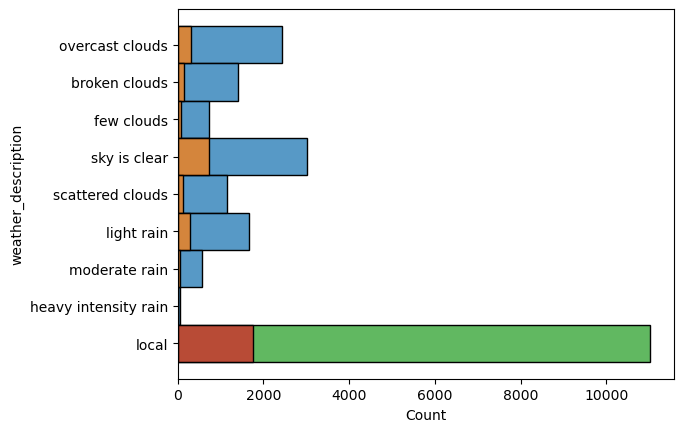

In [8]:



print (df_energia_2021.shape)
print(df_energia_2021.tail())
print (df_train.isna().sum())
print (df_2023.isna().sum())
#sns.histplot(df_train["Injecao na rede (kWh)"])
df_train=df_train.fillna({'Injecao na rede (kWh)': 'None'})

print (df_train.isna().sum())

sns.histplot(df_train["weather_description"],y=df_train["weather_description"])
sns.histplot(df_2023["weather_description"],y=df_2023["weather_description"])

sns.histplot(df_train["city_name"],y=df_train["city_name"])
sns.histplot(df_2023["city_name"],y=df_2023["city_name"])

print(df_train.describe())




print (df_train.shape) # verfiicar se o número de linhas está correto



Tratamento de Dados

Data                        object
Hora                         int64
Normal (kWh)               float64
Horario Economico (kWh)    float64
Autoconsumo (kWh)          float64
Injecao na rede (kWh)       object
dt                           int64
city_name                   object
temp                       float64
feels_like                 float64
temp_min                   float64
temp_max                   float64
pressure                     int64
sea_level                  float64
grnd_level                 float64
humidity                     int64
wind_speed                 float64
rain_1h                    float64
clouds_all                   int64
weather_description         object
Periodo                      int64
dtype: object
Data                           0
Hora                           0
Normal (kWh)                   0
Horario Economico (kWh)        0
Autoconsumo (kWh)              0
Injecao na rede (kWh)          0
dt                             0
city_name           

"\n#churn to nominal\ndf['Churn'] = df['Churn'].astype('category') #.apply(str)\nprint(df.dtypes)\n\n# fazer um matplotlib com os churns \n#print(df.head())\n\nx = df.drop(['Churn','State','Phone'], axis=1)\ny = df['Churn'].to_frame()\n\nx_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2021)\n\nclf = DecisionTreeClassifier(random_state=2021)\n\nclf.fit(x_train, y_train)\n\npredict = clf.predict(x_test)\n\nconfusion_matrix = confusion_matrix(y_test, predict)\n\nprint(confusion_matrix)\n\nprint(confusion_matrix)\n\naccuracy = accuracy_score(y_test, predict)\n\nprint(accuracy)\n\nprecision = precision_score(y_test, predict)\n\nprint(precision)\n\nrecall = recall_score(y_test, predict)\n\nprint(recall)\n\n"

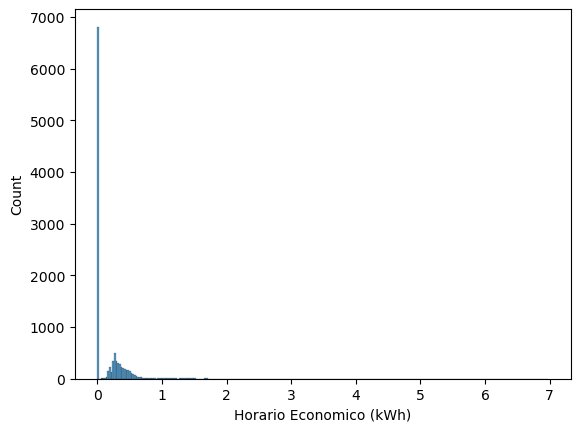

In [9]:
print(df_train.dtypes)
print (df_train.isna().sum())
#print(f"History: {df_train["Horario Economico (kWh)"].hist()}")
sns.histplot(df_train["Horario Economico (kWh)"])
print(df_train["Horario Economico (kWh)"])
#print(dfCSV.head())
#print(dfXLS.head())

form = re.compile(r'\d{4}-(\d{2})-\d{2}')

data= df_train['Data'].str.extract(form)
df_train['Mes']= pd.to_numeric(data[0])
#df_meteo_2023['Hora']= pd.to_numeric(data[1])
data= df_2023['Data'].str.extract(form)
df_2023['Mes']= pd.to_numeric(data[0])


def data_para_estacao(data):
    # Divida a data em mês e dia
    mes, dia = data.month, data.day
    
    # Determine a estação com base no mês e dia
    if (mes > 3 and mes <= 5) or (mes == 3 and dia >= 21) or (mes == 6 and dia < 21):
        return 1
    elif (mes >= 6 and mes <= 8) or (mes == 9 and dia < 23):
        return 2
    elif (mes >= 9 and mes <= 11) or (mes == 12 and dia < 21) :
        return 3
    else:
        return 4

# Converta a coluna 'Data' em datetime
df_train['Data'] = pd.to_datetime(df_train['Data'])

# Aplique a função para obter a estação do ano
df_train['Estacao'] = df_train['Data'].apply(data_para_estacao)


# Converta a coluna 'Data' em datetime
df_2023['Data'] = pd.to_datetime(df_2023['Data'])

# Aplique a função para obter a estação do ano
df_2023['Estacao'] = df_2023['Data'].apply(data_para_estacao)





#form = re.compile(r'\d{4}-\d{2}-(\d{2})')
#data= df_train['Data'].str.extract(form)
#df_train['Dia']= pd.to_numeric(data[0])
#data= df_2023['Data'].str.extract(form)
#df_2023['Dia']= pd.to_numeric(data[0])

df_train['rain_1h'] = df_train['rain_1h'].fillna(0)
df_2023['rain_1h'] = df_2023['rain_1h'].fillna(0)

"""
#churn to nominal
df['Churn'] = df['Churn'].astype('category') #.apply(str)
print(df.dtypes)

# fazer um matplotlib com os churns 
#print(df.head())

x = df.drop(['Churn','State','Phone'], axis=1)
y = df['Churn'].to_frame()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2021)

clf = DecisionTreeClassifier(random_state=2021)

clf.fit(x_train, y_train)

predict = clf.predict(x_test)

confusion_matrix = confusion_matrix(y_test, predict)

print(confusion_matrix)

print(confusion_matrix)

accuracy = accuracy_score(y_test, predict)

print(accuracy)

precision = precision_score(y_test, predict)

print(precision)

recall = recall_score(y_test, predict)

print(recall)

"""

Aprendizagem Supervisionada

0        None
1        None
2        None
3        None
4        None
         ... 
11011    None
11012    None
11013    None
11014    None
11015    None
Name: Injecao na rede (kWh), Length: 11016, dtype: category
Categories (5, object): ['None' < 'Low' < 'Medium' < 'High' < 'Very High']
Data                       datetime64[ns]
Hora                                int64
Normal (kWh)                      float64
Horario Economico (kWh)           float64
Autoconsumo (kWh)                 float64
Injecao na rede (kWh)            category
dt                                  int64
city_name                          object
temp                              float64
feels_like                        float64
temp_min                          float64
temp_max                          float64
pressure                            int64
sea_level                         float64
grnd_level                        float64
humidity                            int64
wind_speed                        float

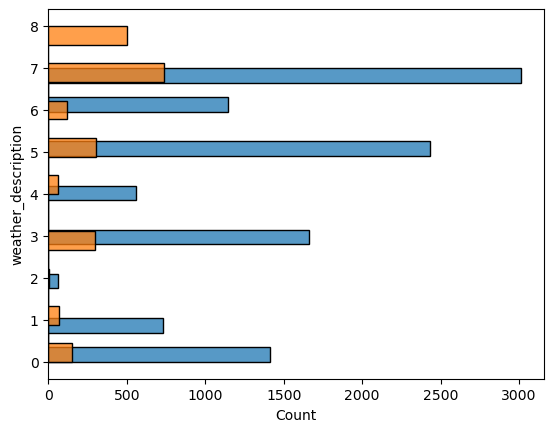

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

#label_encoder = LabelEncoder()
#df_train['Injecao na rede (kWh)'] = label_encoder.fit_transform(df_train['Injecao na rede (kWh)'])
#print(df_train["Injecao na rede (kWh)"])
#ordem_personalizada = ['None', 'Low', 'Medium','High','Very High']

# Inicialize o LabelEncoder
#label_encoder = LabelEncoder()

# Ajuste o LabelEncoder para a ordem personalizada
#label_encoder.fit(ordem_personalizada)

# Aplique o mapeamento ao DataFrame usando o método transform
#df_train['Injecao na rede (kWh)'] = label_encoder.fit_transform(df_train['Injecao na rede (kWh)'])

espectro_cat_type = pd.CategoricalDtype(categories=['None', 'Low', 'Medium','High','Very High'], 
                                        ordered=True)
     

df_train['Injecao na rede (kWh)'] = df_train['Injecao na rede (kWh)'].astype(espectro_cat_type)
#print(df_train.dtypes)
print(df_train['Injecao na rede (kWh)'])


label_encoder = LabelEncoder()
#analisar os valores - não há problema
df_train["weather_description"] = label_encoder.fit_transform(df_train['weather_description'])
#print(df_train["weather_description"])
print(df_train.dtypes)

df_2023["weather_description"] = label_encoder.fit_transform(df_2023['weather_description'])
print(df_2023["weather_description"])


sns.histplot(df_train["weather_description"],y=df_train["weather_description"])
sns.histplot(df_2023["weather_description"],y=df_2023["weather_description"])

# Features and target
print(df_train.dtypes)
x = df_train[["Hora","Normal (kWh)","Horario Economico (kWh)","Autoconsumo (kWh)","temp","pressure","humidity","wind_speed","clouds_all","weather_description",'Periodo',"Mes",'Estacao']]
#x = df_train[["Hora","Normal (kWh)","Horario Economico (kWh)","Autoconsumo (kWh)","temp","feels_like","temp_min","temp_max","pressure","humidity","wind_speed","clouds_all","weather_description","Mes",'Estacao']]

y = df_train["Injecao na rede (kWh)"]

"""
x.drop('Periodo',axis='columns', inplace=True)
correlation_matrix = x.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
#remoção de feels_like. Correlação de 1 com a temperatura
print(y)
"""

# Train the linear regression model
#lm = LinearRegression()
#lm.fit(x, y)

# Your df_2023 data and cleaning operations remain the same

#print(df_2023)
df_2023.drop(['Data'], axis='columns', inplace=True)
#
# df_2023.drop(['Hora'], axis='columns', inplace=True)
df_2023.drop(['city_name'], axis='columns', inplace=True)
df_2023.drop(['grnd_level'], axis='columns', inplace=True)
df_2023.drop(['rain_1h'], axis='columns', inplace=True)
df_2023.drop(['sea_level'], axis='columns', inplace=True)
#df_2023.drop(['weather_description'], axis='columns', inplace=True)
df_2023.drop(['dt'], axis='columns', inplace=True)
df_2023.drop(['feels_like'], axis='columns', inplace=True)
df_2023.drop(['temp_max'], axis='columns', inplace=True)
df_2023.drop(['temp_min'], axis='columns', inplace=True)

print(df_2023.head())
#clf = DecisionTreeClassifier(random_state=2022)

#clf.fit(x, y)

"""
param_grid = {
    'n_estimators': [10,25,50,75,100,150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

# Create a base model
rfc = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, refit=True, verbose=2)

# Fit the grid search to the data
grid_search.fit(x, y)
"""

param_grid = {
    'criterion': ['gini', 'entropy','log_loss'],
    'max_depth': [5,7,9,11,13,15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Crie um modelo de Árvore de Decisão
dt = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,refit=True, verbose=2)
grid_search.fit(x, y)

#descobriu os melhores parametros

clf = grid_search.best_estimator_

print(x.head())
print(df_2023.head())
predict = clf.predict(df_2023)
print(predict)

# Make predictions
#print(df_2023)
#prediction = lm.predict(df_2023)
prediction1=[]
for elem in predict:
    prediction1.append(elem)
"""
for elem in predict:
    if elem <0.5:
        prediction1.append('High')
    elif elem <1.5:
        prediction1.append('Low')
    elif elem <2.5:
        prediction1.append('Medium') 
    elif elem <3.5:
        prediction1.append('None') 
    elif elem <4.5:
        prediction1.append('Very High') 
"""

# Create a DataFrame with 'RowId' and 'Result'
data = pd.DataFrame({'RowId': range(1, len(df_2023) + 1), 'Result': prediction1})

print(df_train.dtypes)
print(df_2023.dtypes)


# Save the data to a CSV file
#print(predict)
data.to_csv('predictions.csv', index=False)

# Print the predictions
#print("Predictions:")
#print(predict)

Geração da submission